In [677]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 02B-Fashion-MNIST-larger-example

In [678]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Dataset

[Fashion MNIST Github Repo](https://github.com/zalandoresearch/fashion-mnist)

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

**Problem** - Given a grayscale image of fashion items predict the class from 10 different classes. Since each image contains only one item, it is a **multiclass-classification problem**.


Type of classification problems:
* Binary - Predict between two mutually exclusive outcomes. (spam or not spam; rain or no rain; positive sentiment or negative sentiment)
* Multiclass - Predict between n mutually exclusive outcomes. (above problem; sunny, rainy, windy;)
* Multilabel - Predict between n outcomes each of which can happen simultaneously (object detection in natural setting images; tags of a webpage/article)

In [679]:
from tensorflow.keras.datasets import fashion_mnist

# The data has already been sorted into training and testing sets
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Name of the classes
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

n_classes = len(class_names)
print(f'Number of classes: {n_classes}')

Number of classes: 10


In [680]:
t = (0, 1, 2, 3) + (4, 4)
t

(0, 1, 2, 3, 4, 4)

In [681]:
train_images.shape, test_images.shape, train_labels.shape, test_labels.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [682]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

**Note**:

* We have 60000 images in training set and 10000 in test set
* The dimension of the image is 28x28 (grayscale, all same dimensions)
* The labels are integer values from 0-9, with mapping in class_names


### Comparing train and test set label distribution


In [772]:
from src.utils import LabelAnalyzer

In [773]:
set.symmetric_difference(set(np.unique(train_labels)), set(np.unique(test_labels)))

set()

All classes are present in both train and test sets

<AxesSubplot:title={'center':'Train vs Test label distribution'}, xlabel='label'>

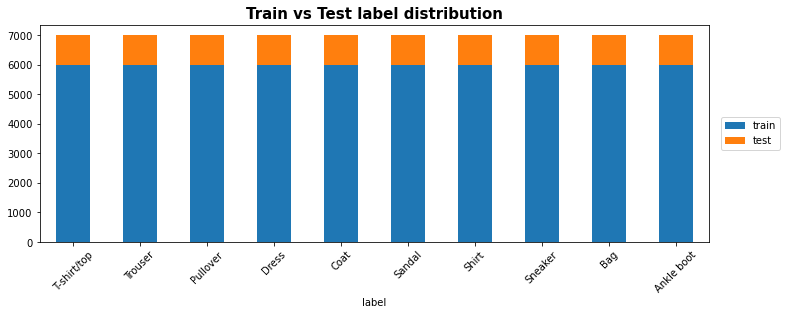

In [774]:
la = LabelAnalyzer(train_labels, test_labels, class_names=class_names)
la.plot()

The distribution is uniform in both with classes equally distributed between themselves as well as between train and test sets! :)

#### Analyzing distribution of classes in a batch of 32

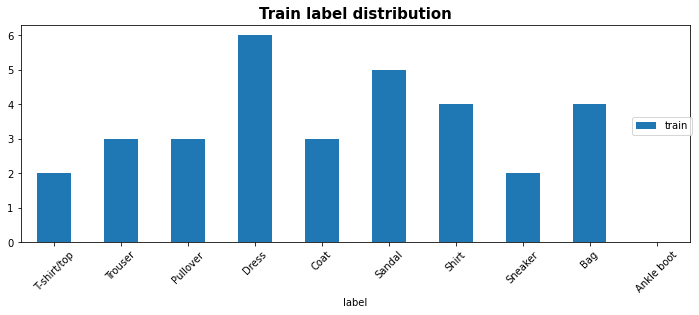

In [775]:
idx = np.random.randint(0, len(train_labels), 32)
la_batch = LabelAnalyzer(train_labels[idx], test_labels=None, class_names=dict(zip(range(0, 10), class_names)))
la_batch.plot();

## Viewing an example image

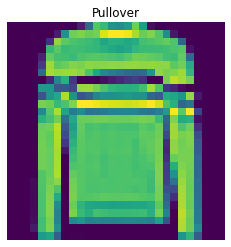

In [776]:
idx = np.random.choice(la.countdf['value'])
img = plt.imshow(train_images[idx])
plt.title(class_names[train_labels[idx]]);
img.axes.set_axis_off()

In [777]:
from matplotlib.gridspec import GridSpec
import copy

In [791]:
class ImageDataset:
    
    def __init__(self, train_data, test_data=None, class_names=None):
        self.train_images, self.train_labels = [x.copy() for x in train_data]
        self.__has_test_data = test_data is not None
        
        if test_data is None:
            test_data = (None, None)
            
        self.test_images, self.test_labels = [x.copy() for x in test_data]
        la = LabelAnalyzer(self.train_labels, self.test_labels, class_names)
        self.__set_attrs_from_labelanalyzer(la)
        
        self.train_size, *self.train_dim = self.train_images.shape
        
        if self.__has_test_data:
            self.test_size, *self.test_dim = self.test_images.shape
    
    def __set_attrs_from_labelanalyzer(self, la):
        self.class_values = la.class_values
        self.class_labels = la.class_labels
        self.n_classes = la.n_classes
        self.val2lab = la.val2lab
        self.lab2val = la.lab2val
        self.labelcountdf = la.countdf
        self.plot_labelcounts = la.plot
        
        
    def __check_test_subset(self, subset):
        if subset == 'test' and not self.__has_test_data:
            raise ValueError('Test data is not provided!')
        
        
    def view_random_images(self, class_labels=None, n_each=1, subset='train', cmap='auto'):
        
        self.__check_test_subset(subset)
        
        subset_labels = self.__getattribute__(f'{subset}_labels')
        subset_images = self.__getattribute__(f'{subset}_images')
        
        
        if cmap == 'auto':
            subset_dim = len(subset_images[0, :].shape)
            if (subset_dim == 2) or (subset_dim == 3 and subset_dim[-1] == 1): 
                cmap = plt.cm.binary
        
        
        if class_labels is None:
            class_labels = self.class_labels
        
        n_classes = len(class_labels)

        fig  = plt.figure(figsize=(n_classes*2, n_each*2))
        gs = GridSpec(n_each, n_classes)
        gs.update(wspace=0.15, hspace=0.05)
        
        # Get class values
        class_values = [self.lab2val[c] for c in class_labels]
        
        # Get label indices for each class
        label_df = pd.DataFrame(subset_labels)
        label_indices = label_df.groupby([0]).indices
        
        # Now sample from chosen class_values
        sample_labels = {k: np.random.choice(label_indices[k], n_each) for k in class_values}
        
            
        for i, (cls_val, indices) in enumerate(sample_labels.items()):
            for j, idx in enumerate(indices):
                
                ax = plt.subplot(gs[j, i])
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                cls_lab = self.val2lab[cls_val]
                img = subset_images[idx]
                ax.imshow(img, cmap=cmap)
                ax.set_axis_off()
                ax.set_aspect('auto')
                
                if j == 0:
                    ax.set_title(cls_lab, fontdict=dict(weight='bold'))
                    
        return gs
    
    
    def select(self, class_labels, apply_on_subset='all'):
        assert apply_on_subset in ['train', 'test', 'all']
        
        if apply_on_subset == 'all':
            chosen_subsets = ['train']
            if self.__has_test_data:
                chosen_subsets.append('test')
        else:
            chosen_subsets = [apply_on_subset] 
            
        kwarg_dict = {'class_names': self.val2lab}
    
        for subset in chosen_subsets:  
            subset_labels = self.__getattribute__(f'{subset}_labels')
            subset_images = self.__getattribute__(f'{subset}_images')

            class_values = [self.lab2val[c] for c in class_labels]
            idx = np.isin(subset_labels, class_values)
            kwarg_dict[f'{subset}_data'] = (subset_images[idx], subset_labels[idx])
            
            
        for subset in ['train', 'test']:
            if not kwarg_dict.get(f'{subset}_data'):
                subset_labels = self.__getattribute__(f'{subset}_labels')
                subset_images = self.__getattribute__(f'{subset}_images')
                kwarg_dict[f'{subset}_data'] = (subset_images, subset_labels)
        
        imgds = self.__class__(**kwarg_dict)
        
        return imgds
          
        
    def sample(self, n):
        pass
    
    
    def get_one_hot_labels(self, subset):
        subset_labels = self.__getattribute__(f'{subset}_labels')
        return tf.keras.utils.to_categorical(subset_labels, num_classes=self.n_classes)
        
        
                          
                          
    
                          
        
        

        
    
        

## Create the `ImageDataset`

In [792]:
imgds = ImageDataset((train_images, train_labels), (test_images, test_labels), class_names)

### Plot the label counts

<AxesSubplot:title={'center':'Train vs Test label distribution'}, xlabel='label'>

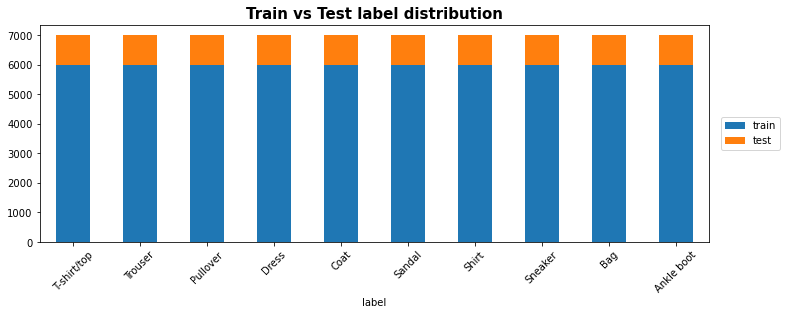

In [793]:
imgds.plot_labelcounts()

### View Random images

#### train

GridSpec(3, 10)

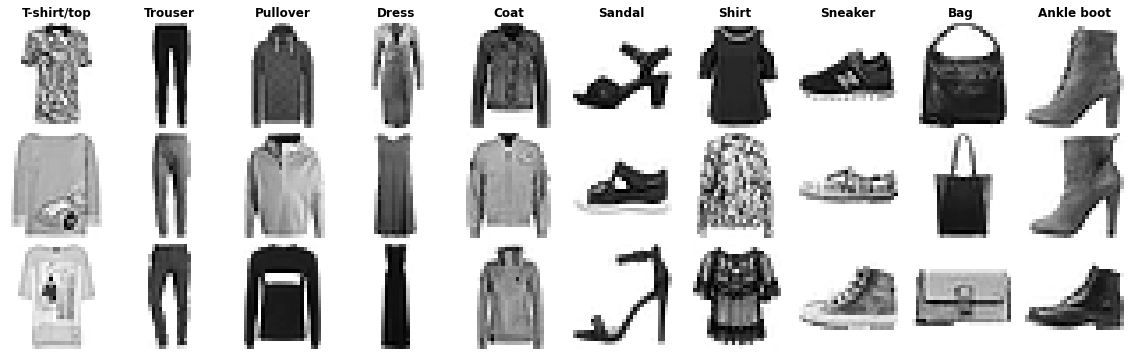

In [794]:
imgds.view_random_images(class_labels=None, n_each=3, subset='train')

#### test

GridSpec(3, 10)

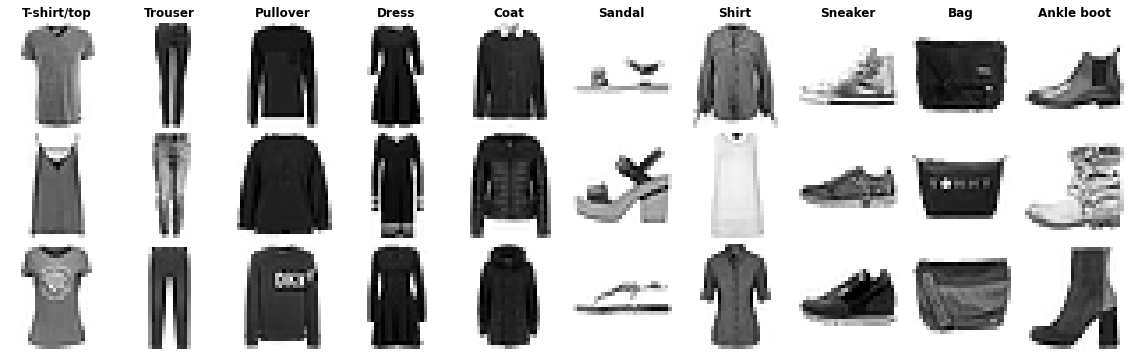

In [795]:
imgds.view_random_images(class_labels=None, n_each=3, subset='test')

### Now select a few classes

* Suppose you want to make separate models for different groups of classes (which appear visually very similar) and then combine their predictions

<AxesSubplot:title={'center':'Train vs Test label distribution'}, xlabel='label'>

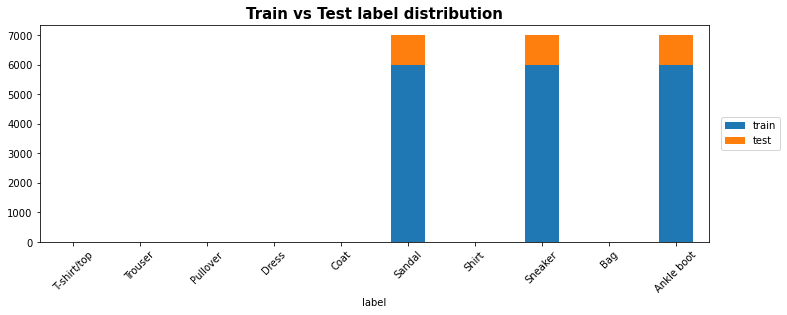

In [796]:
imgds_shoes = imgds.select(class_labels=['Sandal', 'Sneaker', 'Ankle boot'])
imgds_shoes.plot_labelcounts()

## Build a multiclass classification model

* Loss function = `CategoricalCrossentropy` (if one-hot) else `SparseCategoricalCrossentropy`
* Output activation = `Softmax`
* Input shape = 28x28 (shape of one image)
* Output shape = 10 (1 per class)

In [819]:
from tensorflow.keras import layers
from src.utils import plot_keras_model

### Get one hot encoded labels

In [799]:
y_train, y_test = imgds.get_one_hot_labels('train'), imgds.get_one_hot_labels('test')

### Scale the images

* The images are 8bit single channel images (Hence the pixel values are intensities between $0$ and $2^8 - 1 = 255$

In [805]:
print('train:' , imgds.train_images.min(), imgds.train_images.max())
print('test:' , imgds.test_images.min(), imgds.test_images.max())

train: 0 255
test: 0 255


In [802]:
X_train, X_test = imgds.train_images/255.0, imgds.test_images/255.0

In [806]:
print('train:' , X_train.min(), X_train.max())
print('test:' , X_test.min(), X_test.max())

train: 0.0 1.0
test: 0.0 1.0


### The `Flatten` layer

* Before passing the images of dim (28, 28) into a simple Deep Neural Network, we need to flatten the images
* Then we can construct the Neural Network layers as usual
* This makes it loose the spatial correlation property, and model now has no hints whatsoever that some pixels are spatially closer to one another. 

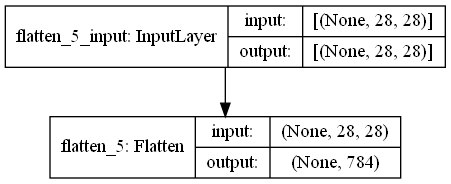

In [822]:
flatten_model = tf.keras.models.Sequential([
    layers.Flatten(input_shape=(imgds.train_dim))
])

plot_keras_model(flatten_model, show_shapes=True)

The flatten layer flattens a (28, 28) into 784 (1-D) vector

In [827]:
X_train.shape, flatten_model.predict(X_train).shape

((60000, 28, 28), (60000, 784))

## `tfmodels`

* A dictionary to hold all the models we create

In [828]:
tfmodels = {}